# Sequence modeling by RNN and k-means clustering

## Introduction to RNN

We first learn how to implement a RNN model (more specifically, LSTM model) in PyTorch by an example of stock index prediction

We start with importing all necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, LSTM, Linear
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Now we load the historical stock index data. 

Text(0, 0.5, 'Stock index')

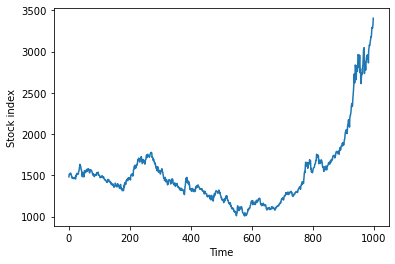

In [2]:
train_ratio = 0.95
valid_ratio = 0.15
predict_day = 1 # The time unit is day
seed = 1
time_step = 20

np.random.seed(seed) 
raw_data = np.loadtxt('data.csv', delimiter=',', dtype=str)
total_data = np.asarray(raw_data[1:, 2:], dtype=float)
num_data = total_data.shape[0]
plt.plot(total_data[3000:4000,0])
plt.xlabel('Time')
plt.ylabel('Stock index')

Then we need to divide all these data into training/validation/testing set. 

For easier training, we will also need to normalize these feature, similar to CNN. 

In [3]:
feat_size = total_data.shape[1]
target_size = 2
num_train = int(num_data*train_ratio)

train_feature = total_data[:num_train, :]
train_target = total_data[predict_day:predict_day + num_train, 0:2]

scaler_feature = StandardScaler()
scaler_target = StandardScaler()
train_feature = scaler_feature.fit_transform(train_feature)
train_target = scaler_target.fit_transform(train_target)

train_x = np.asarray([train_feature[i:i+time_step] for i in range(num_train-time_step)])
train_y = np.asarray([train_target[i:i+time_step] for i in range(num_train-time_step)])

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=valid_ratio, random_state=seed) 
print(train_x.shape, valid_x.shape, train_y.shape, valid_y.shape)

(4915, 20, 7) (868, 20, 7) (4915, 20, 2) (868, 20, 2)


Now let's define the LSTM model

In [4]:
class Model_RNN(Module):
    def __init__(self, input_size, hidden_size, output_size, lstm_layers):
        super(Model_RNN, self).__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size,
                         num_layers=lstm_layers, batch_first=True)
        self.linear = Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        linear_out = self.linear(lstm_out)
        return linear_out, hidden

Since we do not use the data sets provided by PyTorch, we will also need to define the dataloader, which can help us sample data batches from the training/validation data. 

You may also sample data by array slicing operation, yet using dataloader API is often more convenient

In [5]:
batch_size = 64
total_epoch = 20

train_x, train_y = torch.from_numpy(train_x).float(), torch.from_numpy(train_y).float()   
train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size)    

valid_x, valid_y = torch.from_numpy(valid_x).float(), torch.from_numpy(valid_y).float()
valid_loader = DataLoader(TensorDataset(valid_x, valid_y), batch_size=batch_size)

Now let's start training. 

Epoch 1/20
The train loss is 0.292413. 
The valid loss is 0.059692.
Epoch 2/20
The train loss is 0.035428. 
The valid loss is 0.023773.
Epoch 3/20
The train loss is 0.016023. 
The valid loss is 0.011168.
Epoch 4/20
The train loss is 0.007766. 
The valid loss is 0.005652.
Epoch 5/20
The train loss is 0.004146. 
The valid loss is 0.003248.
Epoch 6/20
The train loss is 0.002523. 
The valid loss is 0.002120.
Epoch 7/20
The train loss is 0.001789. 
The valid loss is 0.001646.
Epoch 8/20
The train loss is 0.001482. 
The valid loss is 0.001424.
Epoch 9/20
The train loss is 0.001317. 
The valid loss is 0.001288.
Epoch 10/20
The train loss is 0.001215. 
The valid loss is 0.001203.
Epoch 11/20
The train loss is 0.001152. 
The valid loss is 0.001143.
Epoch 12/20
The train loss is 0.001108. 
The valid loss is 0.001106.
Epoch 13/20
The train loss is 0.001078. 
The valid loss is 0.001084.
Epoch 14/20
The train loss is 0.001058. 
The valid loss is 0.001070.
Epoch 15/20
The train loss is 0.001045. 
Th

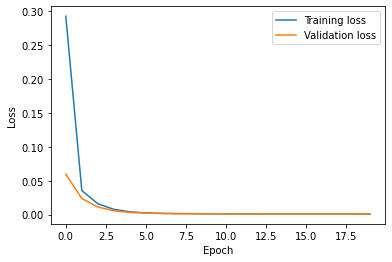

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = Model_RNN(input_size=feat_size, hidden_size=64, output_size=target_size, lstm_layers=2).to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

train_loss = np.zeros(total_epoch)
valid_loss = np.zeros(total_epoch)

for epoch in range(total_epoch):
    print("Epoch {}/{}".format(epoch+1, total_epoch))
    model.train()              
    train_loss_array = []    
    for i, _data in enumerate(train_loader):
        _train_X, _train_Y = _data[0].to(device),_data[1].to(device)
        optimizer.zero_grad()            
        pred_Y, _ = model(_train_X) 
            
        loss = criterion(pred_Y, _train_Y) 
        loss.backward()             
        optimizer.step()              
        train_loss_array.append(loss.item())

    model.eval()                
    valid_loss_array = []
    hidden_valid = None
    for _valid_X, _valid_Y in valid_loader:
        _valid_X, _valid_Y = _valid_X.to(device), _valid_Y.to(device)
        pred_Y, _ = model(_valid_X)
        loss = criterion(pred_Y, _valid_Y) 
        valid_loss_array.append(loss.item())

    train_loss[epoch] = np.mean(train_loss_array)
    valid_loss[epoch] = np.mean(valid_loss_array)
    print("The train loss is {:.6f}. \n".format(train_loss[epoch]) + "The valid loss is {:.6f}.".format(valid_loss[epoch]))

plt.figure()
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now we will test our model on unseen test sets. Since we use some data transformation (normalization) on the input and target for training set, we also need to add them to testing set here. 

In [7]:
test_feature = scaler_feature.transform(total_data[num_train:, :])
sample_interval = min(test_feature.shape[0], time_step)    
start_num_in_test = test_feature.shape[0] % sample_interval  
time_step_size = test_feature.shape[0] // sample_interval

test_x = np.asarray([test_feature[start_num_in_test+i*sample_interval:start_num_in_test+(i+1)*sample_interval] 
                     for i in range(time_step_size)]) 
test_y = total_data[num_train+start_num_in_test:, 0:2]

test_x = torch.from_numpy(test_x).float()
test_set = TensorDataset(test_x)
test_loader = DataLoader(test_set, batch_size=1)
result = torch.Tensor().to(device)

model.eval()
for _data in test_loader:
    data_X = _data[0].to(device)
    pred_X, hidden_predict = model(data_X)
    cur_pred = torch.squeeze(pred_X, dim=0)
    result = torch.cat((result, cur_pred), dim=0)

result = scaler_target.inverse_transform(result.detach().cpu().numpy())

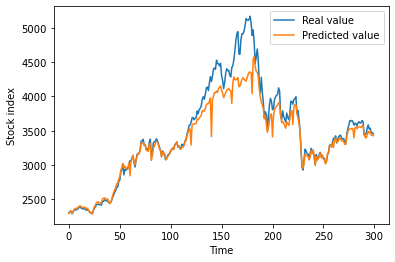

In [8]:
plt.figure()
plt.plot(test_y[:,1], label='Real value')
plt.plot(result[:,1], label='Predicted value')
plt.xlabel('Time')
plt.ylabel('Stock index')
plt.legend()
plt.show()

Hmm...good news is that we get the right general trends, bad news is that we fail to match the peak value. 

Possible reasons include:
- The model is too simple: we only use a 2-layer LSTM layer with 64 hidden units
- The huge rise and fall in testing data is out of the training data distribution, and it is hard for the model to generalize to such wild trend

## K-Means Clustering

Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in scikit-learn. Generally the simplest to understand is *k-means clustering*, which is also taught in class and implemented in ``sklearn.cluster.KMeans`` in scikit-learn.

Similar with before, we begin with the standard imports:

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multi-dimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

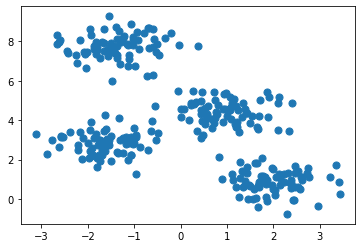

In [10]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

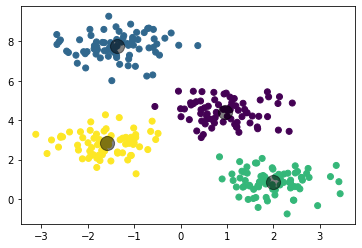

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
